In [95]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api = sj.Shioaji()

In [3]:
api.login('F128497445', 'j7629864')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='F128497445', broker_id='F002000', account_id='1473661', signed=True, username='鄭圳宏'),
 Account(account_type=<AccountType.H: 'H'>, person_id='F128497445', broker_id='9A92', account_id='0011645', username='鄭圳宏'),
 StockAccount(person_id='F128497445', broker_id='9A92', account_id='0231901', signed=True, username='鄭圳宏\u3000\u3000')]

In [275]:
def getNearbyCode(td:datetime):
    month = getNearbyMonth(td)
    return [chr(m+65-1), chr(m+65-1+12)]
    
def getNearbyMonth(td: datetime = None):
    if not td:
        td = datetime.today()
    month = td.month
    if isTimetoMaturity(td): 
        month += 1
        if month > 12:
            month = 1
    return month

def getExistsContract(date: datetime, strikes:list, symbol:str='TXF', months:int=3) -> list:
    global call_code_map, put_code_map, opt_ticker_map
    opt_ticker = opt_ticker_map[symbol]
    Conti_Ms = getExistsContractMonth(date)
    contracts = []
    y = date.year
    next_y = y + 1
    for strike in strikes:
        strike = StrikeFill(strike, symbol)
        
        for m in Conti_Ms[:months]:
            call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(y)[-1]}'
            put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(y)[-1]}'
            if 12 in Conti_Ms[1:3]:
                if m < 12:
                    call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(next_y)[-1]}'
                    put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(next_y)[-1]}'
            contracts.extend([call_ticker, put_ticker])
    return contracts

def getExistsContractMonth(date):
    month = getNearbyMonth(date)
    conti_Ms = [x if x <= 12 else x - 12 for x in range(month, month + 3)]
    if conti_Ms[-1] in [3, 4, 5]: # 3個連續月份的最後一個月是3或4或5，判斷連續季月月份，以下雷同
        conti_Ms.extend([6, 9, 12])
    elif conti_Ms[-1] in [6, 7, 8]:
        conti_Ms.extend([9, 12, 3])
    elif conti_Ms[-1] in [9, 10, 11]:
        conti_Ms.extend([12, 3, 6])
    elif conti_Ms[-1] in [12, 1, 2]:
        conti_Ms.extend([3, 6, 9])
    return conti_Ms

def isTimetoMaturity(td):
    thirdWendesday = getThirdWendesday(td)
    if td.strftime('%Y%m%d') >= thirdWendesday.strftime('%Y%m%d'): 
        return True
    return False

def getThirdWendesday(td):
    week = 2
    first_wendesday = getFirstWendesday(td)
    return first_wendesday + timedelta(week * 7)

def getFirstWendesday(td):
    first_day = datetime(td.year, td.month, 2)
    if first_day.weekday() <= 2:
        adj_days = 2 - first_day.weekday()
    else:
        adj_days = 9 - first_day.weekday()
    return first_day + timedelta(adj_days)

def getContiCode(td:datetime):
    m = getNearbyMonth(td)
    next_m = (m + 1) % 12
    if not next_m:
        next_m = 12
    if m+1 > 12: 
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year + 1)[-1]]
    else:
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year)[-1]]
    

In [276]:
getContiCode(datetime(2021,10,20))

['K1', 'L1']

In [279]:
def GetPairData(api, date:datetime):
    last_code = getContiCode(date)
    today_last_code = getContiCode(datetime.today())
    
    contract_nearby = api.Contracts.Futures["MXF"+today_last_code[0]]
    contract_nearby2 = api.Contracts.Futures["MXF"+today_last_code[1]]
    
    contract_nearby.code = "MXF"+last_code[0]
    contract_nearby2.code = "MXF"+last_code[1]
    
    start_date = date.strftime("%Y-%m-%d")
    data_nearby = api.ticks(contract_nearby, start_date, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',
                           time_end='09:00:00')
    if pd.DataFrame(data_nearby.dict()).empty : return # Market Off
    
    dateStr = (date + timedelta(1)).strftime("%Y-%m-%d")
    data_nearby = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='15:00:00',
                           time_end='23:59:59')
    data_nearby_t1 = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='00:00:00',
                           time_end='05:00:00')
    data_nearby2 = api.ticks(contract_nearby2, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='15:00:00',
                           time_end='23:59:59')
    data_nearby2_t1 = api.ticks(contract_nearby2, dateStr,
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='00:00:00',
                           time_end='05:00:00')

    df_nearby = pd.DataFrame(data_nearby.dict()).append(pd.DataFrame(data_nearby_t1.dict()))
    df_nearby2 = pd.DataFrame(data_nearby2.dict()).append(pd.DataFrame(data_nearby2_t1.dict()))

    df_nearby2['datetime'] = df_nearby2.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(int(x))[:10])).astimezone(pytz.timezone('Asia/Taipei')))# if not np.isnan(x) else x)#.fillna(method='ffill').dropna()
    df_nearby['datetime'] = df_nearby.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(int(x))[:10])).astimezone(pytz.timezone('Asia/Taipei')))# if not np.isnan(x) else x)#.fillna(method='ffill').dropna()
#     print(df_nearby.head())
#     print(df_nearby2.head())
    df_nearby = df_nearby.set_index('datetime')
    df_nearby2 = df_nearby2.set_index('datetime')

    indexes = list(set(list(df_nearby.index)).union(list(df_nearby2.index)))

    final_data = []
    for idx in sorted(indexes):#[:10]:
        nearby_1 = df_nearby.loc[:idx, :]
        try:
            nearby_1_CPrice = nearby_1.close[-1]
            nearby_1_bid = nearby_1.bid_price[-1]
            nearby_1_ask = nearby_1.ask_price[-1]
        except:
            nearby_1_CPrice = float('nan')
            nearby_1_bid = float('nan')
            nearby_1_ask = float('nan')
    
        nearby_2 = df_nearby2.loc[:idx, :]
        try:
            nearby_2_CPrice = nearby_2.close[-1]
            nearby_2_bid = nearby_2.bid_price[-1]
            nearby_2_ask = nearby_2.ask_price[-1]
        except:
            nearby_2_CPrice = float('nan')
            nearby_2_bid = float('nan')
            nearby_2_ask = float('nan')

        final_data.append(
        {
            'datetime':idx,
            'nearby1':nearby_1_CPrice,
            'nearby2':nearby_2_CPrice,
            'nearby1_ask':nearby_1_ask,
            'nearby1_bid':nearby_1_bid,
            'nearby2_ask':nearby_2_ask,
            'nearby2_bid':nearby_2_bid,

        })

    df=pd.DataFrame(final_data)
    if df.empty:return

    df['diff'] = df.nearby2 - df.nearby1
    estimateIdx = df.datetime.apply(lambda x: x.strftime("%H%M%S") <= '093000').index#df[,:].index
    df['diffMean'] = df.loc[estimateIdx,:]['diff'].mean()
    df['diffStd'] = df.loc[estimateIdx,:]['diff'].std()
    df['diffUpBand'] = df['diffMean'] + 1.5 * df['diffStd']
    df['diffDnBand'] = df['diffMean'] - 1.5 * df['diffStd']
    df['diff12'] = df.nearby1_bid - df.nearby2_ask
    df['diff21'] = df.nearby2_bid - df.nearby1_ask
    
    df['mean_diff12'] = df.loc[estimateIdx,:].diff12.mean()
    df['std_diff12'] = df.loc[estimateIdx,:].diff12.std()
    df['upband12'] = df['mean_diff12'] + 1.5 * df['std_diff12']
    df['dnband12'] = df['mean_diff12'] - 1.5 * df['std_diff12']

    df['mean_diff21'] = df.loc[estimateIdx,:].diff21.mean()
    df['std_diff21'] = df.loc[estimateIdx,:].diff21.std()
    df['upband21'] = df['mean_diff21'] + 1.5 * df['std_diff21']
    df['dnband21'] = df['mean_diff21'] - 1.5 * df['std_diff21']
    return df

In [283]:
df = GetPairData(api, date=datetime(2021,8,19))

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: Mat

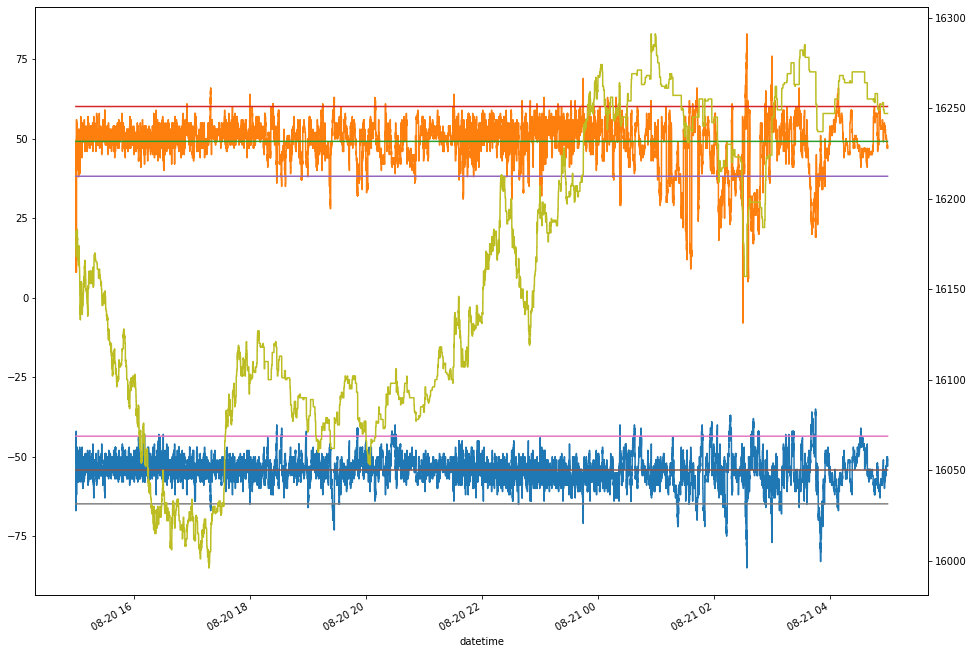

In [284]:
# tmp_df = df.loc[df.index[5500]:df.index[6000],:].set_index('datetime')
tmp_df = df.set_index('datetime')
tmp_df['diff'].plot(label='diff', figsize = (16,12))
tmp_df['diff12'].plot(label='diff12')#, figsize = (16,12))
tmp_df['mean_diff12'].plot(label='mu')
tmp_df['upband12'].plot(label='upband')
tmp_df['dnband12'].plot(label='dnband')
# tmp_df['diff21'].plot(label='diff21', figsize = (16,12))
# tmp_df['diffMean'].plot(label='diffMean', figsize = (16,12))
tmp_df['diffMean'].plot(label='diffmu')#, figsize = (16,12))
(tmp_df['diffMean'] + 2.5 * tmp_df['diffStd']).plot(label='diffUpBand')#, figsize = (16,12))
(tmp_df['diffMean'] - 2.5 * tmp_df['diffStd']).plot(label='diffDnBand')#, figsize = (16,12))
# tmp_df.nearby2.plot(label='nearby2')
tmp_df.nearby2.plot(label='nearby2', secondary_y=True)
plt.show()

In [212]:
df = GetPairData(api, date=datetime(2021,8,28))

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: Mat

<AxesSubplot:label='f70356a6-3ec6-43da-ac8c-7477063a17eb'>

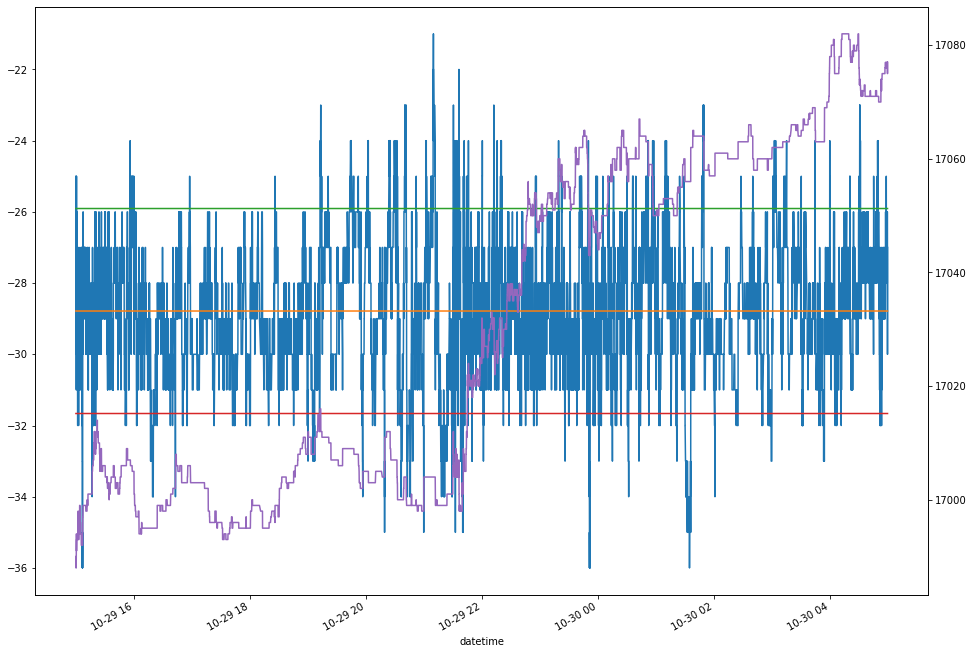

In [213]:
# tmp_df = df.loc[df.index[2500]:df.index[4000],:].set_index('datetime')
tmp_df = df.set_index('datetime')
tmp_df['diff'].plot(label='diff', figsize = (16,12))
# tmp_df['diff12'].plot(label='diff12')#, figsize = (16,12))
# tmp_df['mean_diff12'].plot(label='mu')
# tmp_df['upband12'].plot(label='upband')
# tmp_df['dnband12'].plot(label='dnband')
# tmp_df['diff21'].plot(label='diff21', figsize = (16,12))
# tmp_df['diffMean'].plot(label='diffMean', figsize = (16,12))
tmp_df['diffMean'].plot(label='diffmu')#, figsize = (16,12))
tmp_df['diffUpBand'].plot(label='diffUpBand')#, figsize = (16,12))
tmp_df['diffDnBand'].plot(label='diffDnBand')#, figsize = (16,12))
# tmp_df.nearby2.plot(label='nearby2')
tmp_df.nearby2.plot(label='nearby2', secondary_y=True)

In [290]:
def Backtest(df, takeprofit_reverse = 10, stoploss = 20, takeprofit_trend = 60, profit_enough=10, band_width=2.5):
    diff_12 = []
#     diff_21 = []
    diff = []
    mean_diff = 0
    std_diff = 0
    upband = 0
    dnband = 0
    mean_diff12 = 0
    std_diff12 = 0
    upband12 = 0
    dnband12 = 0
    prices = []
#     mean_diff21 = 0
#     std_diff21 = 0
#     upband21 = 0
#     dnband21 = 0

    setup_param = False
    entry = sig = pos = 0
    result = []
    total_pnl = 0
    total_win = 0
    total_loss = 0
    win_trade = 0
    loss_trade = 0
    record = {}
    end_Trade = False
    max_pnl = 0
    pnl_threshold = 30
    sig_multiplier = 1
    loss_num = 0
    max_unreal = 0
    tmp_sl = stoploss
    entry_abs_diff = 0
    tmp_abs_diff = 0
    pre_date = None
    break_count_up = 0
    break_count_dn = 0
    pre_diff = None
    for row in df.itertuples():
        if not np.isnan(row.nearby2):
            prices.append(row.nearby2)
        if not np.isnan(row.diff12):
            diff_12.append(row.diff12)
#         diff_21.append(row.diff21)
        if not np.isnan(row.diff):
            diff.append(row.diff)
        if pre_date is None:
            pre_date = row.datetime.strftime("%Y-%m-%d")
            pre_diff = row.diff
        if pre_date == row.datetime.strftime("%Y-%m-%d"):
            if row.datetime.strftime("%H%M%S") <= '170000':continue
        if not setup_param:
            mean_diff12 = np.mean(diff_12)
            std_diff12 = np.std(diff_12)
            upband12 = mean_diff12 + band_width * std_diff12
            dnband12 = mean_diff12 - band_width * std_diff12
            
            mean_diff = np.mean(diff)
            std_diff = np.std(diff)
            upband = mean_diff + band_width * std_diff
            dnband = mean_diff - band_width * std_diff
            
            print('Price Std: ',np.std(prices))

#             mean_diff21 = np.mean(diff_21)
#             std_diff21 = np.std(diff_21)
#             upband21 = mean_diff21 + 1 * std_diff21
#             dnband21 = mean_diff21 - 1 * std_diff21
            setup_param = True
        if sig == 0 and pos == 0 and not end_Trade:
#             if row.diff >= upband:# and pre_diff < upband:
#                 break_count_up +=1
#                 break_count_dn = 0
#                 if break_count_up >= 3:
            if (mean_diff - 0.5 * band_width * std_diff >= row.diff and row.diff >= dnband) and (mean_diff12 + 0.5 * band_width * std_diff12 <= row.diff12 and row.diff12 <= upband12):
#             if row.diff12 <= dnband12 and row.diff21 >= upband21:
                sig = 1 * sig_multiplier
#                     break_count_up = 0
            elif (mean_diff12 - 0.5 * band_width * std_diff12 >= row.diff12 and row.diff12 >= dnband12) and (mean_diff + 0.5 * band_width * std_diff <= row.diff and row.diff <= upband):
#             elif row.diff12 >= upband12 and row.diff21 <= dnband21:
#             if row.diff <= dnband and pre_diff > dnband:
#                 break_count_dn += 1
#                 break_count_up = 0
#                 if break_count_dn >= 3:
                sig = -1 * sig_multiplier
#                     break_count_dn = 0
#             elif row.diff21 >= upband:
#                 sig = 1
#             elif row.diff21 <= dnband:
#                 sig = -1
    #         print(f'sig : {sig}')
    #         print(f'upband12 : {upband12}, diff12 : {row.diff12}, dnband12 : {dnband12}')
    #         print(f'upband21 : {upband21}, diff21 : {row.diff21}, dnband21 : {dnband21}\n')
            if sig != 0 and pos == 0:
                if sig > 0:
                    entry  = row.nearby2_ask
                elif sig < 0:
                    entry  = row.nearby2_bid
                if entry == 0:
                    entry = row.nearby2
                pos, sig = sig, 0
#                 entry_abs_diff = abs(row.diff - mean_diff)
                print(f'Entry : {entry}, pos : {pos} at ts : {row.datetime}, Close = {row.nearby2}')
        if sig == 0 and pos != 0:
#             tmp_abs_diff = abs(row.diff - mean_diff)
            if pos < 0:
                exit = min(row.nearby2, row.nearby2_ask)
            elif pos > 0:
                exit = max(row.nearby2_bid, row.nearby2)
            if exit == 0:
                exit = row.nearby2
            tmp_pnl = (exit - entry) * pos
    #         print(f'Exit : {exit}, unrealized pnl : {tmp_pnl}, total_pnl : {total_pnl} at ts : {row.datetime}\n')
#             max_unreal = max(max_unreal, tmp_pnl)
#             tmp_entry = entry + max_unreal * pos
#             moving_exit = tmp_entry - stoploss * pos
#             tmp_sl = stoploss - max_unreal
#             if max_unreal >= 5 and tmp_pnl <= max_unreal - change_stop_loss:
#                 sig =- pos
#             if tmp_abs_diff > entry_abs_diff:        
#                 if row.diff > upband and pos > 0:
#                     sig = -1 * sig_multiplier
#                 if row.diff < dnband and pos < 0:
#                     sig = 1 * sig_multiplier
#             if tmp_abs_diff > entry_abs_diff:
#                 sig = -pos
#             if (pos > 0 and exit < moving_exit) or (pos < 0 and exit > moving_exit):
#                 sig = -pos
            if (tmp_pnl >= takeprofit_reverse and sig_multiplier > 0) or (tmp_pnl >= takeprofit_trend and sig_multiplier < 0):
                sig = -pos
#                 if row.diff12 >= dnband12 and row.diff21 <= upband21:
#                     sig = -pos
#                 elif row.diff12 <= upband12 and row.diff21 >= dnband21:
#                     sig = -pos
#             elif tmp_pnl <= -tmp_sl:# or (total_pnl > pnl_threshold and tmp_pnl <= -min(total_pnl*0.1, stoploss)):
            elif tmp_pnl <= -stoploss:
                sig = -pos

            if sig != 0:
                if pos < 0:
                    exit = row.nearby2_ask
                elif pos > 0:
                    exit = row.nearby2_bid
                if exit == 0:
                    exit = row.nearby2
                pnl = (exit - entry) * pos
                total_pnl += pnl
                if pnl > 0:
                    win_trade += 1
                    total_win += pnl
                if pnl < 0:
                    loss_trade += 1
                    total_loss += pnl
                print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.datetime}, Close = {row.nearby2}\n')
                max_unreal = entry = exit = pos = sig = 0
                max_pnl = max(total_pnl, max_pnl)
#                 print(win_trade + loss_trade, total_pnl < 0,pnl < 0 and sig_multiplier < 0, loss_trade >= 1)
            if (win_trade + loss_trade) > 0:
                if total_pnl < 0:
#                     if loss_num >= 2:
#                         sig_multiplier = -1
#                         stoploss = 30
                    if pnl < 0 and sig_multiplier < 0:
                        sig_multiplier = 1
                    elif loss_trade >= 2:
                        sig_multiplier = -1
                        stoploss *= 2
#                         stoploss = tmp_sl
#                     elif loss_num >= 1:
                        
                    
                
#                 elif tmp_pnl > 0 and sig_multiplier < 0:
#                     loss_num = 0
#                     sig_multiplier = 1
            
    #             if sig_multiplier < 0:
    #                 sig_multiplier = 1
#             if total_pnl <= -stoploss:
#                 end_Trade = True
            if (total_pnl <= -stoploss * 2) or total_pnl >= profit_enough:
                end_Trade = True
#             elif (win_trade + loss_trade) > 0 and max_pnl > 0:
# #                 if max_pnl >= pnl_threshold:
#                 end_Trade = (total_pnl / max_pnl <= 0.8)
            if pre_date != row.datetime.strftime("%Y-%m-%d"):
                end_Trade = (row.datetime.strftime("%H%M%S") >= '043000') or end_Trade
        if pre_date != row.datetime.strftime("%Y-%m-%d"):
            if row.datetime.strftime("%H%M%S") >= '043000':
                if pos != 0:
                    if pos < 0:
                        exit  = row.nearby2_ask
                    elif pos > 0:
                        exit  = row.nearby2_bid
                    pnl = (exit - entry) * pos
                    total_pnl += pnl
                    if pnl > 0:
                        win_trade += 1
                        total_win += pnl
                    if pnl < 0:
                        loss_trade += 1
                        total_loss += pnl
                    print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.datetime}, Close = {row.nearby2}\n')
                    entry = exit = pos = sig = 0
    #                 total_pnl += pnl
                    max_pnl = max(total_pnl, max_pnl)
                endTrade = True
        pre_diff = row.diff
    avg_win = total_win / win_trade if win_trade else 0
    avg_loss = total_loss / loss_trade if loss_trade else 0
    Q = avg_win / abs(avg_loss) if avg_loss else 0
    total_trade = win_trade + loss_trade
    Pw = win_trade / total_trade if total_trade else 0
    Ev = Q * Pw - (1 - Pw)
    Avg_PnL = total_pnl / total_trade if total_trade else 0
    print(f'Total PnL : {total_pnl}')
    print(f'Avg Win : {avg_win}')
    print(f'Num Win : {win_trade}')
    print(f'Avg Loss : {avg_loss}')
    print(f'Num Loss : {loss_trade}')
    print(f'Avg PnL : {Avg_PnL}')
    print(f'G/L : {Q}, Pw : {Pw}, Expected Value : {Ev}')
    print(f'Max Pnl : {max_pnl}\n')
    return (total_pnl, avg_win, win_trade, avg_loss, loss_trade, Avg_PnL, Q, Pw, Ev)

In [288]:
Backtest(df)

Entry : 16026.0, pos : -1 at ts : 2021-08-19 17:00:41+08:00, Close = 16026.0
Exit : 16018.0, pnl : 8.0, total_pnl : 8.0 at ts : 2021-08-19 17:01:52+08:00, Close = 16012.0

Entry : 16020.0, pos : 1 at ts : 2021-08-19 17:03:53+08:00, Close = 16020.0
Exit : 15999.0, pnl : -21.0, total_pnl : -13.0 at ts : 2021-08-19 17:17:16+08:00, Close = 15999.0

Entry : 15998.0, pos : 1 at ts : 2021-08-19 17:17:38+08:00, Close = 15996.0
Exit : 16016.0, pnl : 18.0, total_pnl : 5.0 at ts : 2021-08-19 17:19:32+08:00, Close = 16016.0

Entry : 16020.0, pos : 1 at ts : 2021-08-19 17:19:55+08:00, Close = 16020.0
Exit : 16028.0, pnl : 8.0, total_pnl : 13.0 at ts : 2021-08-19 17:22:02+08:00, Close = 16030.0

Total PnL : 13.0
Avg Win : 11.333333333333334
Num Win : 3
Avg Loss : -21.0
Num Loss : 1
Avg PnL : 3.25
G/L : 0.5396825396825398, Pw : 0.75, Expected Value : 0.15476190476190482
Max Pnl : 13.0



(13.0,
 11.333333333333334,
 3,
 -21.0,
 1,
 3.25,
 0.5396825396825398,
 0.75,
 0.15476190476190482)

In [291]:
date = datetime(2021,10,27)
df = GetPairData(api, date=date)
# if df is None:continue
print(dateStr)
results[dateStr] = Backtest(df)

2021-10-21
Price Std:  10.152838585034269
Entry : 17004.0, pos : 1 at ts : 2021-10-27 17:01:49+08:00, Close = 17003.0
Exit : 17014.0, pnl : 10.0, total_pnl : 10.0 at ts : 2021-10-27 17:18:30+08:00, Close = 17014.0

Total PnL : 10.0
Avg Win : 10.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 10.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 10.0



In [292]:
results = {}
for date in pd.date_range(datetime(2021,8,18), datetime(2021,11,5)):
    df = GetPairData(api, date=date)
    if df is None:continue
    print(date)
    results[date] = Backtest(df)

2021-08-18 00:00:00
Price Std:  14.57367455218246
Entry : 16599.0, pos : 1 at ts : 2021-08-18 17:00:09+08:00, Close = 16595.0
Exit : 16578.0, pnl : -21.0, total_pnl : -21.0 at ts : 2021-08-18 18:20:36+08:00, Close = 16578.0

Entry : 16587.0, pos : 1 at ts : 2021-08-18 18:29:37+08:00, Close = 16587.0
Exit : 16594.0, pnl : 7.0, total_pnl : -14.0 at ts : 2021-08-18 18:35:10+08:00, Close = 16598.0

Entry : 16601.0, pos : 1 at ts : 2021-08-18 18:40:56+08:00, Close = 16598.0
Exit : 16600.0, pnl : -1.0, total_pnl : -15.0 at ts : 2021-08-18 18:52:50+08:00, Close = 16611.0

Entry : 16602.0, pos : -1 at ts : 2021-08-18 18:58:48+08:00, Close = 16612.0
Exit : 16594.0, pnl : 8.0, total_pnl : -7.0 at ts : 2021-08-19 01:37:29+08:00, Close = 16591.0

Entry : 16591.0, pos : -1 at ts : 2021-08-19 01:39:20+08:00, Close = 16592.0
Exit : 16543.0, pnl : 48.0, total_pnl : 41.0 at ts : 2021-08-19 03:53:43+08:00, Close = 16531.0

Total PnL : 41.0
Avg Win : 21.0
Num Win : 3
Avg Loss : -11.0
Num Loss : 2
Avg PnL

2021-09-02 00:00:00
Price Std:  18.73256303275824
Entry : 17338.0, pos : 1 at ts : 2021-09-02 17:00:08+08:00, Close = 17338.0
Exit : 17346.0, pnl : 8.0, total_pnl : 8.0 at ts : 2021-09-02 20:36:56+08:00, Close = 17348.0

Entry : 17346.0, pos : -1 at ts : 2021-09-02 20:41:10+08:00, Close = 17346.0
Exit : 17343.0, pnl : 3.0, total_pnl : 11.0 at ts : 2021-09-02 21:59:14+08:00, Close = 17336.0

Total PnL : 11.0
Avg Win : 5.5
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 5.5
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 11.0

2021-09-03 00:00:00
Price Std:  10.496946182396862
Entry : 17405.0, pos : -1 at ts : 2021-09-03 17:01:47+08:00, Close = 17405.0
Exit : 17425.0, pnl : -20.0, total_pnl : -20.0 at ts : 2021-09-03 18:37:29+08:00, Close = 17425.0

Entry : 17424.0, pos : 1 at ts : 2021-09-03 18:56:18+08:00, Close = 17424.0
Exit : 17424.0, pnl : 0.0, total_pnl : -20.0 at ts : 2021-09-03 19:25:52+08:00, Close = 17434.0

Entry : 17430.0, pos : 1 at ts : 2021-09-03 19:41:41+08:00, Close =

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0

2021-09-22 00:00:00
Price Std:  12.745716177094932
Entry : 16857.0, pos : 1 at ts : 2021-09-22 17:20:11+08:00, Close = 16857.0
Exit : 16855.0, pnl : -2.0, total_pnl : -2.0 at ts : 2021-09-22 18:16:21+08:00, Close = 16873.0

Entry : 16875.0, pos : 1 at ts : 2021-09-22 18:20:35+08:00, Close = 16875.0
Exit : 16855.0, pnl : -20.0, total_pnl : -22.0 at ts : 2021-09-22 19:55:49+08:00, Close = 16855.0

Entry : 16856.0, pos : -1 at ts : 2021-09-22 20:19:06+08:00, Close = 16860.0
Exit : 16937.0, pnl : -81.0, total_pnl : -103.0 at ts : 2021-09-23 04:30:01+08:00, Close = 16932.0

Total PnL : -103.0
Avg Win : 0
Num Win : 0
Avg Loss : -34.333333333333336
Num Loss : 3
Avg PnL : -34.333333333333336
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0

2021-09-23 00:00:00
Price Std:  11.048656464968579
Entry : 17102.0, pos : -1 at ts : 2021-09-23 17:08:51+08:00, Close = 17102


Total PnL : 12.0
Avg Win : 6.0
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 6.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 12.0

2021-10-08 00:00:00
Price Std:  16.48858038917914
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0

2021-10-12 00:00:00
Price Std:  31.666614270919766
Entry : 16504.0, pos : 1 at ts : 2021-10-12 17:06:25+08:00, Close = 16504.0
Exit : 16511.0, pnl : 7.0, total_pnl : 7.0 at ts : 2021-10-12 17:15:48+08:00, Close = 16515.0

Entry : 16515.0, pos : 1 at ts : 2021-10-12 17:16:23+08:00, Close = 16515.0
Exit : 16495.0, pnl : -20.0, total_pnl : -13.0 at ts : 2021-10-12 17:47:49+08:00, Close = 16495.0

Entry : 16494.0, pos : -1 at ts : 2021-10-12 17:47:59+08:00, Close = 16492.0
Exit : 16485.0, pnl : 9.0, total_pnl : -4.0 at ts : 2021-10-12 18:11:22+08:00, Close = 16484.0

Entry : 16481.0, pos : -1 at ts : 2021-10-12 18:12:08+08:00, Close = 16482.0
Exit : 16501.0, pnl : -20.0, total_pn

Total PnL : 13.0
Avg Win : 6.5
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 6.5
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 13.0

2021-11-01 00:00:00
Price Std:  4.0892672297623776
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0

2021-11-02 00:00:00
Price Std:  6.229010338571919
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0

2021-11-03 00:00:00
Price Std:  11.978514178542506
Entry : 17108.0, pos : 1 at ts : 2021-11-03 17:04:35+08:00, Close = 17108.0
Exit : 17113.0, pnl : 5.0, total_pnl : 5.0 at ts : 2021-11-03 17:10:54+08:00, Close = 17118.0

Entry : 17116.0, pos : -1 at ts : 2021-11-03 17:13:56+08:00, Close = 17119.0
Exit : 17109.0, pnl : 7.0, total_pnl : 12.0 at ts : 2021-11-03 17:31:57+08:00, Close = 17106.0

Total PnL : 12.0
Avg Win : 6.0
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 6.0
G/L : 0, Pw : 1.0, Expected Va

In [293]:
cum_pnl = []
for d, res in results.items():
    print(d, res[0])
    if len(cum_pnl):
        cum_pnl.append(cum_pnl[-1] + res[0])
    else:
        cum_pnl.append(res[0])

2021-08-18 00:00:00 41.0
2021-08-19 00:00:00 13.0
2021-08-20 00:00:00 15.0
2021-08-23 00:00:00 0
2021-08-24 00:00:00 -71.0
2021-08-25 00:00:00 16.0
2021-08-26 00:00:00 0
2021-08-27 00:00:00 0
2021-08-30 00:00:00 11.0
2021-08-31 00:00:00 -25.0
2021-09-01 00:00:00 12.0
2021-09-02 00:00:00 11.0
2021-09-03 00:00:00 -76.0
2021-09-06 00:00:00 -52.0
2021-09-07 00:00:00 0
2021-09-08 00:00:00 10.0
2021-09-09 00:00:00 0
2021-09-10 00:00:00 12.0
2021-09-13 00:00:00 18.0
2021-09-14 00:00:00 17.0
2021-09-15 00:00:00 0
2021-09-22 00:00:00 -103.0
2021-09-23 00:00:00 11.0
2021-09-24 00:00:00 11.0
2021-09-27 00:00:00 0
2021-09-28 00:00:00 25.0
2021-09-29 00:00:00 10.0
2021-09-30 00:00:00 53.0
2021-10-01 00:00:00 44.0
2021-10-04 00:00:00 0
2021-10-05 00:00:00 0
2021-10-06 00:00:00 -260.0
2021-10-07 00:00:00 12.0
2021-10-08 00:00:00 0
2021-10-12 00:00:00 -109.0
2021-10-13 00:00:00 15.0
2021-10-14 00:00:00 18.0
2021-10-15 00:00:00 14.0
2021-10-18 00:00:00 -111.0
2021-10-19 00:00:00 -73.0
2021-10-20 00:00:

In [294]:
cum_pnl

[41.0,
 54.0,
 69.0,
 69.0,
 -2.0,
 14.0,
 14.0,
 14.0,
 25.0,
 0.0,
 12.0,
 23.0,
 -53.0,
 -105.0,
 -105.0,
 -95.0,
 -95.0,
 -83.0,
 -65.0,
 -48.0,
 -48.0,
 -151.0,
 -140.0,
 -129.0,
 -129.0,
 -104.0,
 -94.0,
 -41.0,
 3.0,
 3.0,
 3.0,
 -257.0,
 -245.0,
 -245.0,
 -354.0,
 -339.0,
 -321.0,
 -307.0,
 -418.0,
 -491.0,
 -491.0,
 -474.0,
 -474.0,
 -474.0,
 -474.0,
 -464.0,
 -539.0,
 -526.0,
 -526.0,
 -526.0,
 -514.0,
 -474.0,
 -460.0]